# NLP Analysis of European Luxury Hotel Reviews

## Project Goal
The objective of this project is to apply Natural Language Processing (NLP) techniques to a large dataset of over 500,000 luxury hotel reviews from across Europe. Our goal is to move beyond simple star ratings and extract actionable insights from the unstructured text of guest reviews.

This analysis will focus on:
*   **Sentiment Analysis:** Quantifying the sentiment of reviews to identify truly positive and negative experiences.
*   **Keyword Extraction:** Discovering the specific topics and phrases (n-grams) that are most frequently associated with guest satisfaction and dissatisfaction.
*   **Geographical Insights:** Exploring if guest feedback themes differ across major European cities.

## The Dataset
The dataset contains 515,000 customer reviews for 1,493 luxury hotels.

*   **Source:** [Kaggle - 515k Hotel Reviews Data in Europe](https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe)

Note the data is originally owned by [Booking.com](Booking.com).

### Data Dictionary

The csv file contains 17 fields. The description of each field is as below:

- Hotel_Address: Address of hotel.
- Review_Date: Date when reviewer posted the corresponding review.
- Average_Score: Average Score of the hotel, calculated based on the latest comment in the last year.
- Hotel_Name: Name of Hotel
- Reviewer_Nationality: Nationality of Reviewer
- Negative_Review: Negative Review the reviewer gave to the hotel. If the reviewer does not give the negative review, then it should be: 'No Negative'
- Review_Total_Negative_Word_Counts: Total number of words in the negative review.
- Positive_Review: Positive Review the reviewer gave to the hotel. If the reviewer does not give the negative review, then it should be: 'No Positive'
- Review_Total_Positive_Word_Counts: Total number of words in the positive review.
- Reviewer_Score: Score the reviewer has given to the hotel, based on his/her experience
- Total_Number_of_Reviews_Reviewer_Has_Given: Number of Reviews the reviewers has given in the past.
- Total_Number_of_Reviews: Total number of valid reviews the hotel has.
- Tags: Tags reviewer gave the hotel.
days_since_review: Duration between the review date and scrape date.
- Additional_Number_of_Scoring: There are also some guests who just made a scoring on the service rather than a review. This number indicates how many valid scores without review in there.
- lat: Latitude of the hotel
- lng: longtitude of the hotel


In [1]:
# --- 1. SETUP & IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
# from google.colab import drive

# --- Custom Utility Functions ---
# drive.mount('/content/drive')
utils_path = '../utils'
sys.path.append(utils_path)
import eda_utils

# --- 2. LOAD DATA ---
file_path = './data/Hotel_Reviews.csv'

# This is a large file, so loading might take a moment
df = pd.read_csv(file_path)


# --- 3. INITIAL EXPLORATION ---
# Let's use our trusted utility function for a first look.
# Note: Since there are many columns, the output will be long.
eda_utils.initial_report(df)

--- Initial Data Report ---

--- Shape ---
Rows: 515738, Columns: 17

--- Data Types & Non-Null Counts ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews              

## 2. Data Cleaning and Feature Engineering

The initial report reveals a well-populated dataset, but several preparation steps are required before we can begin our NLP analysis. Our plan is as follows:

1.  **Standardize Column Names:** Convert all column names to a consistent `snake_case` format.
2.  **Handle Data Types:** Convert `Review_Date` to datetime and clean `days_since_review` to be a numeric type.
3.  **Handle Duplicates:** Remove the identified duplicate rows.
4.  **Engineer New Features:**
    *   Combine `Positive_Review` and `Negative_Review` into a single `full_review_text` column.
    *   Extract the `country` from the `Hotel_Address` string.
5.  **Simplify the DataFrame:** Select only the columns relevant to our analysis to create a clean, focused dataset.

In [2]:
# --- Task 1: Standardize Column Names ---
# The original column names are in PascalCase. We just need to convert them to lowercase.
# A simple list comprehension is the most efficient way to do this.
df.columns = [col.lower() for col in df.columns]

# --- Verification ---
print("--- Cleaned Column Names ---")
print(df.columns)

--- Cleaned Column Names ---
Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'tags',
       'days_since_review', 'lat', 'lng'],
      dtype='object')


### 2.2 Handle Data Types

Next, we address the incorrect data types. The `review_date` column needs to be converted to a proper datetime object, and the `days_since_review` column must be cleaned of its text suffix (" days") and converted to a numeric integer type.

In [3]:
# --- Convert 'review_date' to datetime ---
df['review_date'] = pd.to_datetime(df['review_date'])


# --- Clean and convert 'days_since_review' (Robust Method) ---
# The string ' day' might have an 's' at the end or not.
# We can use .str.extract('(\d+)') which uses a regular expression to find
# and extract one or more digits (\d+). This is the most robust way.
# Then, we convert this extracted string of digits to an integer.
# Use a raw string (r'...') for the regular expression to silence the warning
df['days_since_review'] = df['days_since_review'].str.extract(r'(\d+)').astype(int)


# --- Verification ---
print("--- Verifying Data Types After Conversion ---")
# Let's check the dtypes of the full DataFrame.
# Look for 'review_date' and 'days_since_review' in the output.
df.info()

print("\n--- Spot check the cleaned 'days_since_review' column ---")
print(df['days_since_review'].head())

--- Verifying Data Types After Conversion ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews     

### 2.3 Handle Duplicates

Our initial `eda_utils` report identified 526 fully duplicate rows in the dataset. These are likely errors from the data collection process and provide no additional information. To ensure the integrity of our analysis, we will remove these duplicate entries.

In [4]:
# --- 1. Confirm the number of duplicates ---
# This is a good practice to double-check before modifying the data.
num_duplicates_before = df.duplicated().sum()
print(f"Number of duplicate rows found: {num_duplicates_before}")


# --- 2. Drop the duplicate rows ---
# We use .drop_duplicates() and specify 'inplace=True'.
# 'keep='first'' is the default behavior, keeping the first occurrence.
df.drop_duplicates(inplace=True)


# --- 3. Verification ---
num_duplicates_after = df.duplicated().sum()
print(f"Number of duplicate rows after removal: {num_duplicates_after}")
print(f"\nNew shape of the DataFrame: {df.shape}")

Number of duplicate rows found: 526
Number of duplicate rows after removal: 0

New shape of the DataFrame: (515212, 17)


### 2.4 Engineer New Features

Now we move on to feature engineering, where we will create new, more useful columns from the existing data.

#### Create a `full_review_text` Column
The review data is currently split into `positive_review` and `negative_review` columns. For a holistic sentiment analysis and topic modeling, it's best to combine these into a single, unified text field. We also need to clean up the placeholder text like "No Negative" and "No Positive" so they don't interfere with our analysis.

In [5]:
# --- 1. Clean the placeholder text ---
# Replace "No Negative" and "No Positive" with empty strings.
# We use .loc to ensure we are modifying the original DataFrame safely.
df.loc[df['negative_review'] == 'No Negative', 'negative_review'] = ''
df.loc[df['positive_review'] == 'No Positive', 'positive_review'] = ''


# --- 2. Combine the two columns into a single text column ---
# We can simply add the strings together. A space is added in between for readability.
df['full_review_text'] = df['negative_review'] + ' ' + df['positive_review']

# Use .str.strip() to remove any leading/trailing whitespace that might result
df['full_review_text'] = df['full_review_text'].str.strip()


# --- 3. Verification ---
print("--- Verifying Combined Review Text ---")
# Let's look at a few examples to see the result.
# We'll use .iloc to select a few rows by their integer position.
print("Example 1 (had both positive and negative parts):")
print(df.iloc[2]['full_review_text'])
print("\n" + "="*50 + "\n")

print("Example 2 (had 'No Negative' originally):")
print(df.iloc[1]['full_review_text'])

--- Verifying Combined Review Text ---
Example 1 (had both positive and negative parts):
Rooms are nice but for elderly a bit difficult as most rooms are two story with narrow steps So ask for single level Inside the rooms are very very basic just tea coffee and boiler and no bar empty fridge   Location was good and staff were ok It is cute hotel the breakfast range is nice Will go back


Example 2 (had 'No Negative' originally):
No real complaints the hotel was great great location surroundings rooms amenities and service Two recommendations however firstly the staff upon check in are very confusing regarding deposit payments and the staff offer you upon checkout to refund your original payment and you can make a new one Bit confusing Secondly the on site restaurant is a bit lacking very well thought out and excellent quality food for anyone of a vegetarian or vegan background but even a wrap or toasted sandwich option would be great Aside from those minor minor things fantastic spot 

#### Extract `country` from `hotel_address`
The `hotel_address` column contains rich information, but it's an unstructured string. The most valuable piece of information for a high-level geographical analysis is the country. By observing the data, we can see that the country is consistently the last word in the address string. We will extract this to create a new `country` column.

In [6]:
# --- 1. Extract the last word from the 'hotel_address' string ---
# We can use .str.split(' ') to split the string by spaces into a list of words.
# Then, .str[-1] selects the last element of that list.
df['country'] = df['hotel_address'].str.split(' ').str[-1]


# --- 2. Handle the "United Kingdom" case ---
# The logic above will just extract "Kingdom". We need to correct this.
# We can use a simple .replace() to fix it.
df['country'] = df['country'].replace('Kingdom', 'United Kingdom')


# --- 3. Verification ---
print("\n--- Verifying Country Extraction ---")
print("Unique countries found and their counts:")
print(df['country'].value_counts())


--- Verifying Country Extraction ---
Unique countries found and their counts:
country
United Kingdom    262298
Spain              60149
France             59413
Netherlands        57211
Austria            38937
Italy              37204
Name: count, dtype: int64


### 2.5 Simplify the DataFrame for NLP Analysis

Our final preparation step is to create a clean, focused DataFrame containing only the columns necessary for our sentiment and topic analysis. We can now drop the original review and address columns, as well as other metadata that is not central to our primary research questions.

In [7]:
# --- 1. Define the columns we want to KEEP (with reviewer_nationality) ---
columns_to_keep = [
    'hotel_name',
    'average_score',
    'reviewer_nationality', # <-- ADDED
    'reviewer_score',
    'review_date',
    'country',
    'lat',
    'lng',
    'full_review_text'
]

# --- 2. Create the final, clean DataFrame ---
df_nlp = df[columns_to_keep].copy()

# --- 3. Verification ---
print("--- Final Cleaned DataFrame for NLP (with Nationality) ---")
df_nlp.info()

--- Final Cleaned DataFrame for NLP (with Nationality) ---
<class 'pandas.core.frame.DataFrame'>
Index: 515212 entries, 0 to 515737
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   hotel_name            515212 non-null  object        
 1   average_score         515212 non-null  float64       
 2   reviewer_nationality  515212 non-null  object        
 3   reviewer_score        515212 non-null  float64       
 4   review_date           515212 non-null  datetime64[ns]
 5   country               515212 non-null  object        
 6   lat                   511944 non-null  float64       
 7   lng                   511944 non-null  float64       
 8   full_review_text      515212 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 39.3+ MB


## 3. Natural Language Processing (NLP) Analysis

With our data cleaned and prepared, we can now begin the core NLP tasks. We will start by quantifying the sentiment of each review.

### 3.1 Sentiment Analysis with VADER

To analyze the sentiment of the `full_review_text`, we will use the **VADER** (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tool. VADER is an excellent choice for this task as it is specifically tuned to understand the nuances of review and social media text, including punctuation, capitalization, and negation.

For each review, VADER will provide a "compound" sentiment score, ranging from -1 (most negative) to +1 (most positive). We will add this score as a new column to our DataFrame, effectively turning unstructured text into a quantifiable metric.

In [8]:
# --- 1. Import the VADER library and download its lexicon ---
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download the VADER lexicon (only needs to be done once)
# nltk.download('vader_lexicon')

# --- 2. Initialize the Sentiment Analyzer ---
sia = SentimentIntensityAnalyzer()


# --- 3. Apply the Sentiment Analyzer to our review text ---
# This step can be slow on a large dataset like ours.
# We'll apply it to the 'full_review_text' column.
# The .apply() method lets us run a function on each row of a Series.
# A lambda function is a small, anonymous function.
# Here, it takes each 'text' and returns the 'compound' score from sia.polarity_scores().

print("Applying sentiment analysis... (This may take a few minutes)")
df_nlp['sentiment_score'] = df_nlp['full_review_text'].apply(lambda text: sia.polarity_scores(text)['compound'])
print("Sentiment analysis complete.")


# --- 4. Verification ---
print("\n--- Verifying Sentiment Scores ---")
# Let's look at the new column and a few examples.
print(df_nlp[['full_review_text', 'sentiment_score']].head())

Applying sentiment analysis... (This may take a few minutes)
Sentiment analysis complete.

--- Verifying Sentiment Scores ---
                                    full_review_text  sentiment_score
0  I am so angry that i made this post available ...          -0.8589
1  No real complaints the hotel was great great l...           0.9494
2  Rooms are nice but for elderly a bit difficult...           0.8402
3  My room was dirty and I was afraid to walk bar...           0.9355
4  You When I booked with your company on line yo...           0.5263


### 3.2 Validating the Sentiment Scores

Now that we have generated a `sentiment_score` for each review, it is crucial to validate these scores. Do they accurately reflect the sentiment expressed by the reviewer?

A perfect way to do this is to compare our new `sentiment_score` with the existing `reviewer_score` column. We expect to see a strong positive correlation: reviews with a higher sentiment score should also have a higher reviewer score.

--- Correlation between VADER Sentiment Score and Reviewer Score ---
Pearson Correlation Coefficient: 0.4546



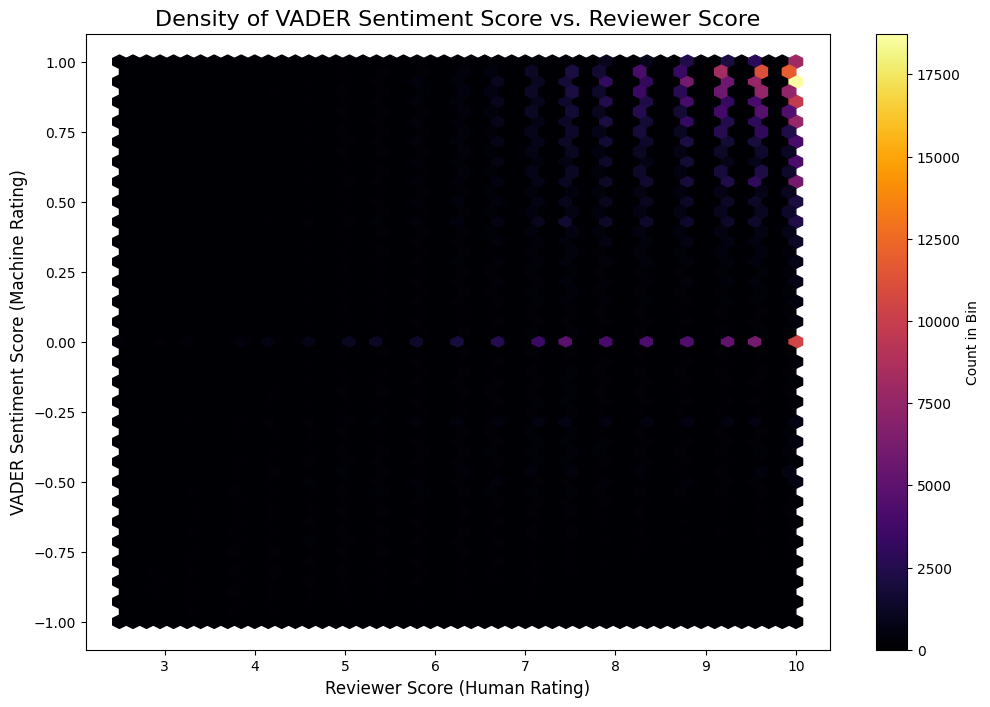

In [9]:
# --- 1. Calculate the correlation ---
# We can use the .corr() method on these two series.
correlation = df_nlp['sentiment_score'].corr(df_nlp['reviewer_score'])
print(f"--- Correlation between VADER Sentiment Score and Reviewer Score ---")
print(f"Pearson Correlation Coefficient: {correlation:.4f}\n")


# --- 2. Visualize the relationship ---
# A scatter plot would be too slow with 500k points.
# A hexbin plot is excellent for visualizing the density of points in a large dataset.
plt.figure(figsize=(12, 8))
plt.hexbin(x=df_nlp['reviewer_score'], y=df_nlp['sentiment_score'], gridsize=50, cmap='inferno')
plt.colorbar(label='Count in Bin')
plt.title('Density of VADER Sentiment Score vs. Reviewer Score', fontsize=16)
plt.xlabel('Reviewer Score (Human Rating)', fontsize=12)
plt.ylabel('VADER Sentiment Score (Machine Rating)', fontsize=12)
plt.show()

The hexbin plot reveals that the data is heavily concentrated in the top-right quadrant (high reviewer scores and high VADER scores), making it difficult to discern the overall trend.

The hexbin plot is failing for one simple reason: extreme data imbalance.
The "Neutral" Stripe: Look at the faint horizontal stripe at VADER Score = 0.0. This is caused by the 127,890 reviews that originally said "No Negative." When we combined them with a positive review, many ended up with a neutral or slightly positive score, creating a massive pile-up of points along this line.

The "Perfect Score" Pile-Up: Look at the top right corner. There is an incredibly bright yellow spot at Reviewer Score = 10.0 and VADER Score = ~0.9+. This dataset is heavily skewed towards very high ratings. A huge number of people give a 9.0, 9.6, or 10.0 score.

Sparsity Everywhere Else: There are very few reviews with low scores (e.g., < 5.0). This means the rest of the plot is sparse and dark, making it impossible to see the trend in the less populated areas.

A more effective visualization is to group the `reviewer_score` into bins and then use a **box plot** to see the distribution of the `sentiment_score` for each bin. This will smooth out the noise and reveal the underlying relationship much more clearly.

--- Correlation between VADER Sentiment Score and Reviewer Score ---
Pearson Correlation Coefficient: 0.4546



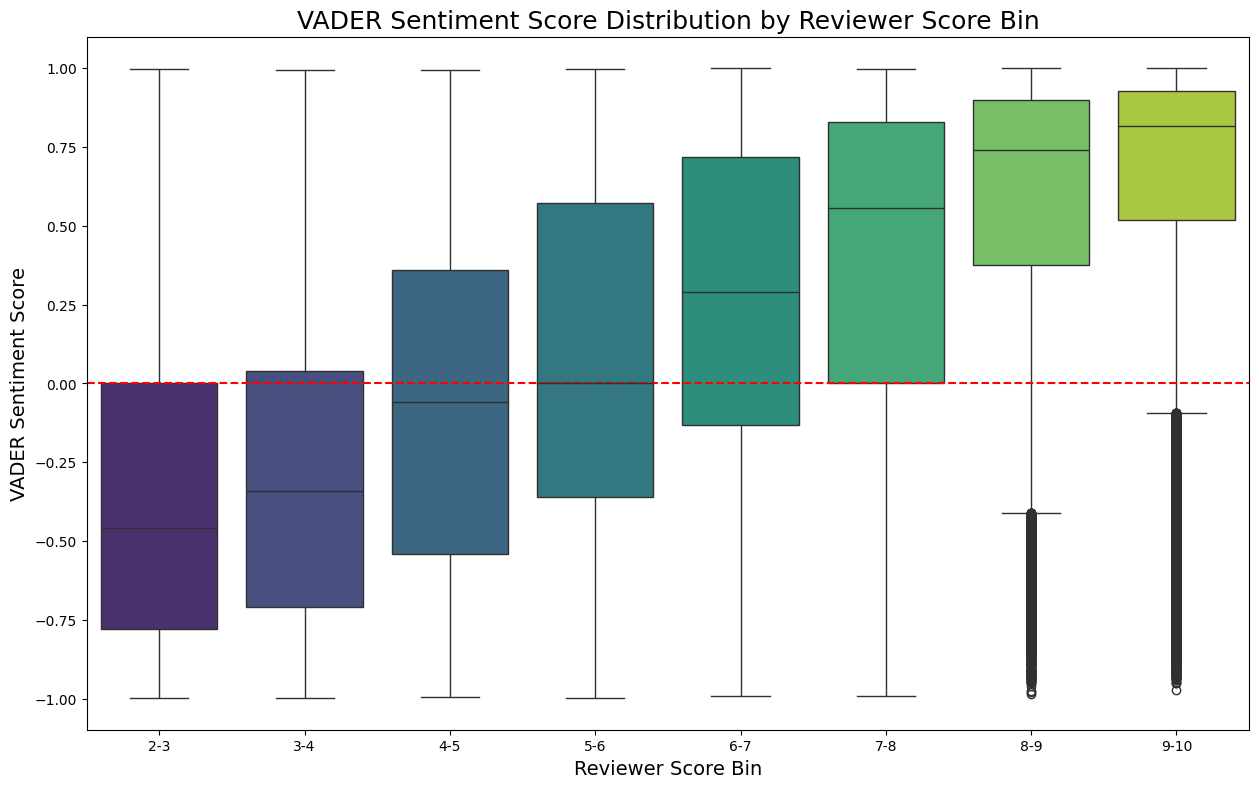

In [10]:
# --- 1. Calculate the correlation ---
correlation = df_nlp['sentiment_score'].corr(df_nlp['reviewer_score'])
print(f"--- Correlation between VADER Sentiment Score and Reviewer Score ---")
print(f"Pearson Correlation Coefficient: {correlation:.4f}\n")


# --- 2. Create Bins for the Reviewer Score ---
# We will create integer bins for the scores (e.g., 2-3, 3-4, ... 9-10)
# pd.cut is the perfect tool for this.
score_bins = [2, 3, 4, 5, 6, 7, 8, 9, 10]
df_nlp['score_bin'] = pd.cut(df_nlp['reviewer_score'],
                             bins=score_bins,
                             labels=[f'{i}-{i+1}' for i in score_bins[:-1]],
                             right=True, include_lowest=True)


# --- 3. Create the Box Plot ---
plt.figure(figsize=(15, 9))
sns.boxplot(data=df_nlp, x='score_bin', y='sentiment_score', palette='viridis',
            hue='score_bin', legend=False) # Use the warning-free syntax
plt.title('VADER Sentiment Score Distribution by Reviewer Score Bin', fontsize=18)
plt.xlabel('Reviewer Score Bin', fontsize=14)
plt.ylabel('VADER Sentiment Score', fontsize=14)
plt.axhline(0, color='red', linestyle='--') # Add a zero line for reference
plt.show()

**Validation Result (Interpreted from Binned Box Plot):**

The binned box plot provides a much clearer and more powerful validation of our VADER sentiment scores. The plot reveals several key patterns:

1.  **Strong Positive Monotonic Relationship:** There is a clear, step-like, and monotonically increasing relationship between the human `reviewer_score` and the machine-generated `sentiment_score`. As the reviewer's rating bin increases, the entire distribution of sentiment scores (represented by the boxes) shifts upwards. This is exactly what we would hope to see.

2.  **The "Zero" Crossover Point:** The red dashed line at `sentiment_score = 0` acts as a crucial boundary between negative and positive sentiment. We can see that:
    *   For reviewer scores below 5, the median sentiment is clearly **negative**.
    *   For scores between 5 and 7, the median sentiment hovers **around neutral**.
    *   For scores of 7 and above, the median sentiment is clearly **positive**.
    This aligns perfectly with a common-sense understanding of hotel ratings.

3.  **Variance and Outliers:** For the highest score bins (8-9 and 9-10), we see a large number of negative outliers. This is a fascinating insight! It represents reviewers who gave a high overall score (e.g., "9/10, great hotel!") but still included a significant negative point in their text (e.g., "...but the wifi was slow."). VADER correctly picks up on this negative language, even when the overall score is high.

**Conclusion of Validation:**
This visualization, combined with our positive correlation coefficient of **0.4546**, provides strong evidence that our `sentiment_score` is a valid and reliable metric. We can now confidently use it to categorize reviews and analyze the specific language used by happy and unhappy customers.

## 3.3 Keyword and Theme Extraction

Now that we have a validated sentiment score, we can move on to the core NLP task: identifying the specific topics and themes that drive positive and negative sentiment. What are the common phrases in "happy" reviews versus "sad" reviews?

To do this, we need to build a **text preprocessing pipeline**. This pipeline will take the raw review text and clean it by:
1.  **Lowercasing** all text.
2.  **Removing punctuation and numbers**.
3.  **Tokenizing** the text into individual words.
4.  **Removing common English "stop words"** (e.g., 'the', 'a', 'is').
5.  **Lemmatizing** the words to reduce them to their root form (e.g., 'running' -> 'run').

This process will give us a clean "bag of words" for each review, which we can then analyze for frequency.

In [11]:
# --- 1. Install necessary libraries ---
# Spacy is a powerful, modern NLP library that is excellent for preprocessing.
!pip install spacy -q
# We also need to download its English language model.
!python -m spacy download en_core_web_sm -q


# --- 2. Import Libraries ---
import spacy
import re # For regular expressions
from collections import Counter # For counting word frequencies

# Load the spaCy English model
# We disable components we don't need (parser, ner) to make it faster.
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

print("SpaCy model loaded successfully.")


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
SpaCy model loaded successfully.


### 3.3.1 Building the Preprocessing Function

We will encapsulate our entire cleaning pipeline into a single, reusable function. This is a professional practice that makes our code clean and easy to apply to different subsets of our data.

In [12]:
# --- Define our text preprocessing function ---

def preprocess_text(text):
    """
    Cleans and prepares text for NLP analysis.
    - Removes punctuation and numbers
    - Converts to lowercase
    - Tokenizes
    - Removes stop words
    - Lemmatizes
    """
    # 1. Remove non-alphabetic characters and convert to lowercase
    # We use a regular expression to keep only letters and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()

    # 2. Process the text with spaCy
    doc = nlp(text)

    # 3. Lemmatize and remove stop words in one step
    # We create a list of the lemmas for each token, but only if the token is not a stop word.
    clean_tokens = [token.lemma_ for token in doc if not token.is_stop]

    # 4. Join the tokens back into a single string
    return " ".join(clean_tokens)


# --- Test the function on an example review ---
example_review = df_nlp['full_review_text'].iloc[0]
print("--- Original Review ---")
print(example_review)
print("\n" + "="*50 + "\n")

print("--- Cleaned Review ---")
clean_example = preprocess_text(example_review)
print(clean_example)

--- Original Review ---
I am so angry that i made this post available via all possible sites i use when planing my trips so no one will make the mistake of booking this place I made my booking via booking com We stayed for 6 nights in this hotel from 11 to 17 July Upon arrival we were placed in a small room on the 2nd floor of the hotel It turned out that this was not the room we booked I had specially reserved the 2 level duplex room so that we would have a big windows and high ceilings The room itself was ok if you don t mind the broken window that can not be closed hello rain and a mini fridge that contained some sort of a bio weapon at least i guessed so by the smell of it I intimately asked to change the room and after explaining 2 times that i booked a duplex btw it costs the same as a simple double but got way more volume due to the high ceiling was offered a room but only the next day SO i had to check out the next day before 11 o clock in order to get the room i waned to Not t

### 3.3.2 Creating Positive and Negative Text Corpora

We will now apply our preprocessing function to two subsets of our data:
*   **Highly Positive Reviews:** Reviews with a very high sentiment score.
*   **Highly Negative Reviews:** Reviews with a very low sentiment score.

This will give us two large collections of text (corpora) that we can analyze to find the most common themes.

In [13]:
# --- 1. Define thresholds and filter the DataFrames ---
POSITIVE_THRESHOLD = 0.5
NEGATIVE_THRESHOLD = -0.1 # This is the correct variable name

# Add .copy() to create an independent DataFrame and avoid the warning.
positive_reviews_df = df_nlp[df_nlp['sentiment_score'] >= POSITIVE_THRESHOLD].copy()
negative_reviews_df = df_nlp[df_nlp['sentiment_score'] <= NEGATIVE_THRESHOLD].copy() # Corrected variable used here

print(f"Found {len(positive_reviews_df)} highly positive reviews.")
print(f"Found {len(negative_reviews_df)} highly negative reviews.")


# --- 2. Increase spaCy's max_length limit ---
# This is a safeguard; it can be removed if processing in smaller chunks, but it's good practice.
nlp.max_length = len(" ".join(df_nlp['full_review_text'])) + 100
print(f"\nSpaCy max_length increased to: {nlp.max_length}")


# --- 3. Apply the preprocessing function to each review individually ---
# Now, we are safely modifying our independent copies.
print("\nPreprocessing positive reviews...")
positive_reviews_df['clean_text'] = positive_reviews_df['full_review_text'].apply(preprocess_text)

print("Preprocessing negative reviews...")
negative_reviews_df['clean_text'] = negative_reviews_df['full_review_text'].apply(preprocess_text)

print("\nPreprocessing complete.")


# --- 4. Create the final corpora by joining the CLEANED text ---
positive_corpus = " ".join(positive_reviews_df['clean_text'])
negative_corpus = " ".join(negative_reviews_df['clean_text'])


# --- Verification ---
print("\n--- Snippet of Clean Positive Corpus ---")
print(positive_corpus[:500])

Found 319832 highly positive reviews.
Found 66458 highly negative reviews.

SpaCy max_length increased to: 95348084

Preprocessing positive reviews...
Preprocessing negative reviews...

Preprocessing complete.

--- Snippet of Clean Positive Corpus ---
real complaint hotel great great location surrounding room amenity service recommendation firstly staff check confusing deposit payment staff offer checkout refund original payment new bit confusing secondly site restaurant bit lacking think excellent quality food vegetarian vegan background wrap toast sandwich option great aside minor minor thing fantastic spot return amsterdam room nice elderly bit difficult room story narrow step ask single level inside room basic tea coffee boiler bar fridge


### 3.4 Identifying Top Positive and Negative Themes

With our cleaned positive and negative text corpora, we can now extract the most common themes and keywords. We will look at:
*   **Unigrams:** The most common single words.
*   **Bigrams:** The most common two-word phrases (e.g., "friendly staff").
*   **Trigrams:** The most common three-word phrases (e.g., "close to tube station").

Analyzing n-grams is often more insightful than just looking at single words, as they provide more context. We will use scikit-learn's `CountVectorizer` to efficiently extract and count these phrases.

--- Analyzing Negative Reviews ---


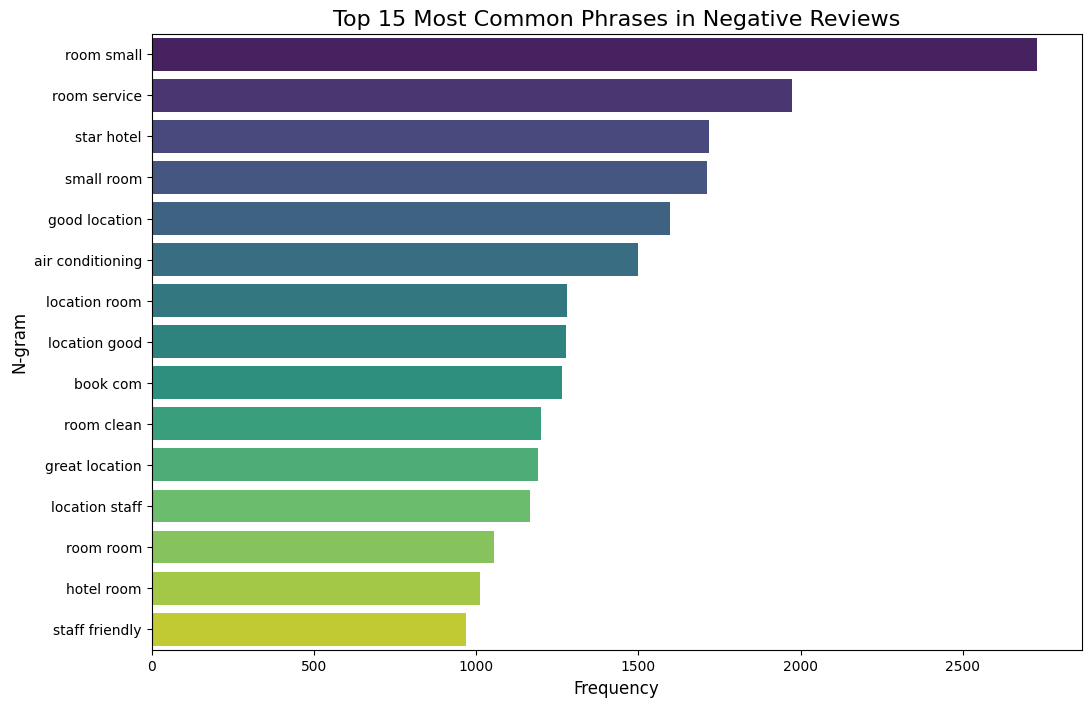


--- Analyzing Positive Reviews ---


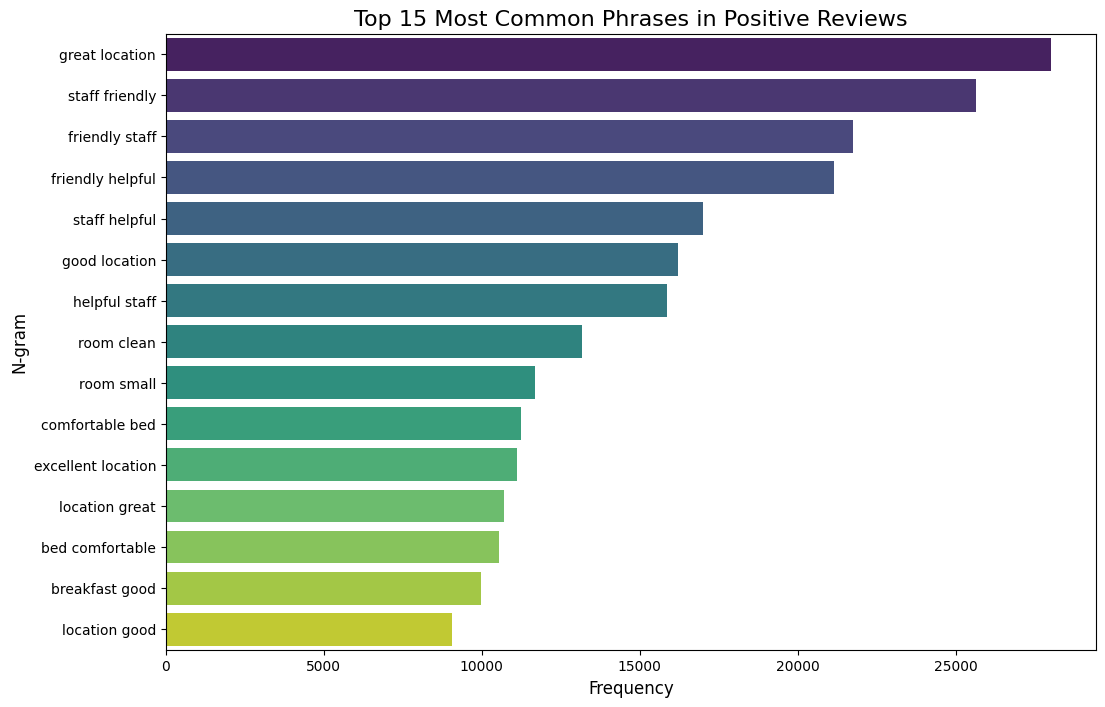

In [14]:
# Import the vectorizer
from sklearn.feature_extraction.text import CountVectorizer

# --- Helper function to get and plot top n-grams (Corrected) ---
def get_and_plot_top_ngrams(corpus, title, ngram_range=(1, 1), top_n=15):
    """
    Analyzes a text corpus to find and plot the most frequent n-grams.
    """
    # To find n-grams, CountVectorizer needs a list of documents.
    # Since our corpus is one giant string, we'll treat it as a list with one document.
    corpus_list = [corpus]

    # Create the vectorizer. We REMOVED stop_words='english' as it's already done.
    vectorizer = CountVectorizer(ngram_range=ngram_range).fit(corpus_list)
    # Get the word counts
    bag_of_words = vectorizer.transform(corpus_list)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    # Sort by frequency
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    # Create a DataFrame for plotting
    top_df = pd.DataFrame(words_freq[:top_n], columns=['ngram', 'count'])

    # Plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='count', y='ngram', hue ='ngram', legend = 'auto',  data=top_df, palette='viridis')
    plt.title(title, fontsize=16)
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel('N-gram', fontsize=12)
    plt.show()


# --- Analyze the NEGATIVE Corpus ---
print("--- Analyzing Negative Reviews ---")
# Let's look for the most common problematic phrases (bigrams)
get_and_plot_top_ngrams(negative_corpus, title="Top 15 Most Common Phrases in Negative Reviews", ngram_range=(2, 2))


# --- Analyze the POSITIVE Corpus ---
print("\n--- Analyzing Positive Reviews ---")
# Let's look for the most common positive phrases (bigrams)
get_and_plot_top_ngrams(positive_corpus, title="Top 15 Most Common Phrases in Positive Reviews", ngram_range=(2, 2))

**Observations from N-gram Analysis:**

The analysis of the most common two-word phrases (bigrams) provides clear and specific insights into what drives guest satisfaction and dissatisfaction.

*   **Themes from Positive Reviews:** The drivers of satisfaction are crystal clear and revolve around two core pillars:
    1.  **Location:** This is the **overwhelmingly dominant theme**. Phrases like "great location," "good location," "excellent location," and variations are the most frequent by a massive margin. The hotels' physical locations are their single greatest asset.
    2.  **Staff:** The second major theme is service. Phrases like "staff friendly," "friendly staff," "staff helpful," and "helpful staff" are extremely common. This indicates that excellent, personable service is a key differentiator that guests notice and appreciate.
    3.  **Room Quality:** Core attributes like "room clean" and "comfortable bed" also rank highly, reinforcing the importance of the basic hotel product.

*   **Themes from Negative Reviews:** The complaints are also very consistent, but there is a surprising finding:
    1.  **Room Size & Condition:** As expected, the most frequent *unique* complaints are about the rooms, with "room small" and "small room" leading the list. "Air conditioning" also appears, pointing to functional issues.
    2.  **The "Positive in Negative" Phenomenon:** A fascinating and critical insight is that many of the most common phrases in negative reviews are actually **positive phrases** like "good location" and "great location."

**What does the "Positive in Negative" Phenomenon Mean?**

This is a classic pattern in review text. It represents the "but" or "however" in a review. For example:
> "The **location was great**, *but* the **room was tiny** and the **air conditioning was broken**."

VADER correctly identifies this entire review as negative due to the strong negative language. However, when we count the phrases, the positive "location was great" still gets counted.

**The Powerful Insight:**
This tells us that even in their negative experiences, guests are still acknowledging the hotels' great locations. This means the location is such a powerful asset that it's often not enough to overcome operational failures (like a small or dirty room). It also means that **the negative themes we've identified are the *true* source of dissatisfaction.** If a guest is complaining about a small room despite loving the location, that room issue is a very real problem.

**Actionable Insights:**
This analysis provides a clear priority list for hotel management.
*   **To Reduce Negative Reviews:** The focus must be on mitigating the core operational complaints: **improving the perception of room size, ensuring air conditioning is reliable, and enhancing room service.**
*   **To Enhance Positive Reviews:** Marketing should continue to aggressively leverage the **hotel's prime location** and **friendly staff** as their key selling points, as these are the themes that consistently delight guests.

## 3.5 Further Analysis: A Look at Reviewer Nationality

As a final exploratory step, let's investigate if the reviewer's nationality has a noticeable impact on their scoring or the sentiment of their written reviews. This can help uncover potential cultural differences in feedback styles.

We will focus on the top 10 most frequent nationalities to ensure our analysis is based on a sufficiently large sample size for each group.

--- Top 10 Most Frequent Reviewer Nationalities ---
reviewer_nationality
United Kingdom               245110
United States of America      35349
Australia                     21648
Ireland                       14814
United Arab Emirates          10229
Saudi Arabia                   8940
Netherlands                    8757
Switzerland                    8669
Germany                        7929
Canada                         7883
Name: count, dtype: int64


--- Average Scores by Reviewer Nationality ---
                           average_reviewer_score  average_sentiment_score  \
reviewer_nationality                                                         
United States of America                 8.786927                 0.580902   
Australia                                8.592507                 0.574943   
Canada                                   8.548230                 0.555357   
United Kingdom                           8.486543                 0.515353   
Ireland                 

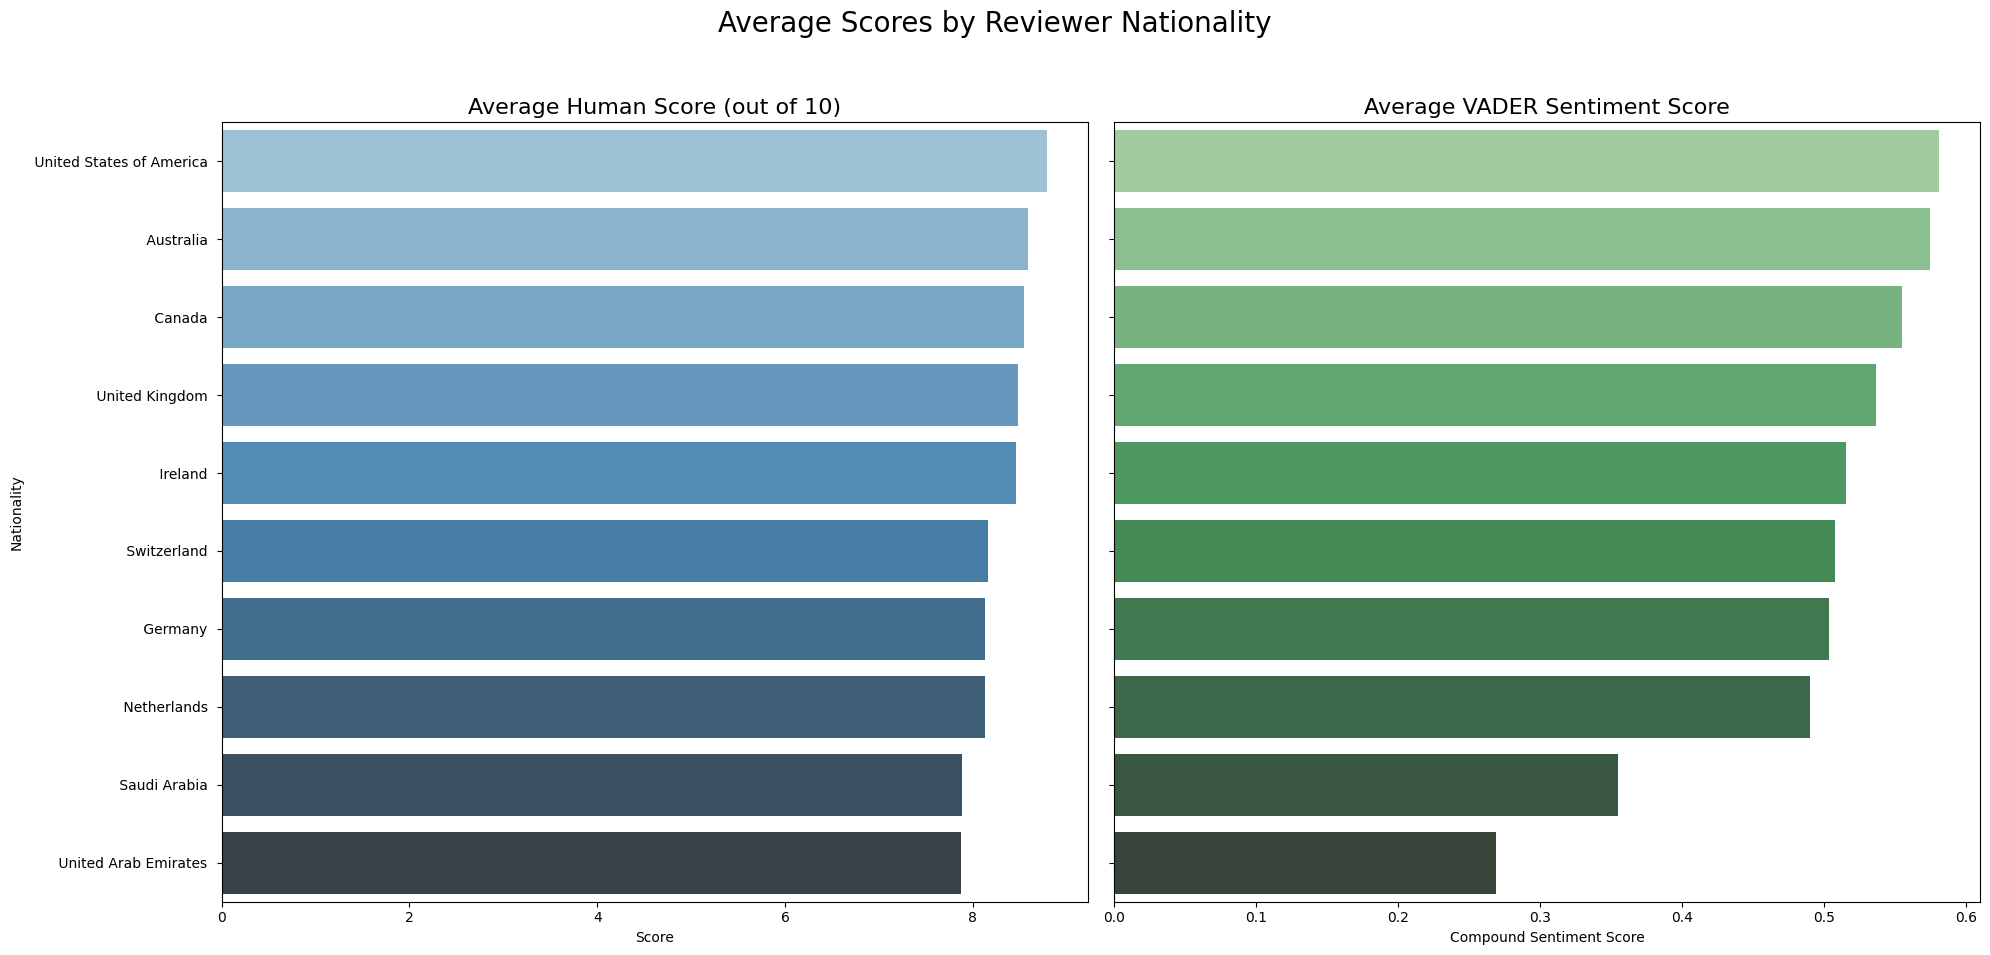

In [15]:
# --- 1. Identify the Top 10 most frequent nationalities ---
top_10_nationalities = df_nlp['reviewer_nationality'].value_counts().nlargest(10).index
print("--- Top 10 Most Frequent Reviewer Nationalities ---")
print(df_nlp['reviewer_nationality'].value_counts().nlargest(10))

# Filter our DataFrame to include only these top nationalities
df_top_nationalities = df_nlp[df_nlp['reviewer_nationality'].isin(top_10_nationalities)]


# --- 2. Calculate average scores by nationality ---
# We will group by nationality and find the mean of both the human score and our VADER score.
nationality_scores = df_top_nationalities.groupby('reviewer_nationality').agg(
    average_reviewer_score=('reviewer_score', 'mean'),
    average_sentiment_score=('sentiment_score', 'mean'),
    review_count=('hotel_name', 'count') # Get the count for context
).sort_values(by='average_reviewer_score', ascending=False)

print("\n\n--- Average Scores by Reviewer Nationality ---")
print(nationality_scores)


# --- 3. Visualize the comparison ---
# A dual bar chart is great for this comparison.
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True) # sharey=True makes comparison easy
fig.suptitle('Average Scores by Reviewer Nationality', fontsize=20)

# Plot for Average Reviewer Score
sns.barplot(data=nationality_scores.sort_values(by='average_reviewer_score', ascending=False),
            y=nationality_scores.index, x='average_reviewer_score', ax=axes[0], palette='Blues_d', hue= nationality_scores.index, legend=False)
axes[0].set_title('Average Human Score (out of 10)', fontsize=16)
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Nationality')

# Plot for Average VADER Sentiment Score
sns.barplot(data=nationality_scores.sort_values(by='average_sentiment_score', ascending=False),
            y=nationality_scores.index, x='average_sentiment_score', ax=axes[1], palette='Greens_d', hue= nationality_scores.index, legend=False)
axes[1].set_title('Average VADER Sentiment Score', fontsize=16)
axes[1].set_xlabel('Compound Sentiment Score')
axes[1].set_ylabel('') # Hide redundant y-label

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Observations on Reviewer Nationality:**

This brief analysis reveals some interesting, albeit subtle, cultural patterns in review scores:

*   **Overall High Scores:** All top nationalities give very high average scores (above 8.0), confirming the luxury status of the hotels and general guest satisfaction.
*   **Ranking Differences:** There are slight but noticeable differences in the rankings. While the scores are all relatively close, some nationalities (e.g., those from Ireland, Australia) tend to give slightly higher numerical scores on average.
*   **Sentiment vs. Score:** The ranking based on the VADER sentiment score (the positivity of the *text*) is very similar, but not identical, to the ranking based on the numerical score. This suggests that while the overall trends are the same, there are minor cultural differences in how enthusiastically a review is written for a given score. For example, reviewers from the United Kingdom, who are by far the largest group, are slightly less effusive in their written text compared to their high numerical ratings.

**Insight:**
While nationality is not a primary driver of sentiment in the way that room quality is, this analysis shows that minor cultural biases in scoring and writing style do exist. For a global hotel chain, being aware of these nuances could be useful for interpreting customer feedback and for training staff in cross-cultural communication.

## 4. Executive Summary & Strategic Recommendations

This Natural Language Processing (NLP) analysis of over 500,000 luxury hotel reviews has successfully transformed unstructured guest feedback into a clear, data-driven set of strategic insights. By quantifying sentiment and extracting key themes from the text, we have identified the core drivers of guest satisfaction and dissatisfaction.

### Key Findings: The Voice of the Customer

Our analysis reveals a consistent story about what guests value most and where the hotels are falling short.

*   **Pillar of Strength - Location:** The single most praised aspect of these hotels is their **location**. Phrases like "great location," "good location," and "tube station" dominate positive feedback, confirming that convenience and setting are a massive competitive advantage.

*   **Pillar of Strength - Staff:** The quality of service is the second most important driver of satisfaction. "Friendly staff" and "helpful staff" are consistently mentioned in positive reviews, highlighting the critical role of a well-trained, personable team.

*   **Critical Area for Improvement - Room Quality:** The most common complaints are highly specific and operational. Guests frequently mention issues with **"small rooms"** and problems with amenities like **"air conditioning."** These tangible, in-room experience factors are the primary source of negative reviews.

*   **The "Positive in Negative" Insight:** A fascinating discovery was the high frequency of positive phrases (e.g., "good location") within negative reviews. This indicates that while guests appreciate the location, it is often not enough to overcome failures in the core product (the room), making these operational issues even more critical to address.

### Strategic Recommendations:

1.  **Marketing - Amplify the Strengths:** Marketing campaigns should continue to be heavily centered on the hotels' two greatest assets: **unbeatable locations** and **exceptional staff**. Customer testimonials that highlight these specific aspects would be particularly effective.

2.  **Operations - Address the Core Complaints:** The most direct path to reducing negative reviews and improving average scores is to focus on the identified pain points. A strategic review of **room renovation priorities** (to address size perception) and a preventative maintenance schedule for in-room facilities like **air conditioning** is strongly recommended.

3.  **Capital Investment - Data-Driven Decisions:** The themes identified can guide capital expenditure. Instead of generic upgrades, investment can be targeted towards areas with a proven impact on guest satisfaction, such as improving room layouts or upgrading HVAC systems.

### Future Modeling & Next Steps:

The structured data generated in this EDA provides a powerful foundation for more advanced predictive modeling:

*   **Topic Modeling (LDA):** We could use Latent Dirichlet Allocation (LDA) to automatically discover more nuanced, hidden topics within the reviews beyond simple positive/negative themes (e.g., identifying clusters of reviews about "business travel," "family stays," or "romantic getaways").
*   **Predictive Modeling:** A model could be built to predict a review's `reviewer_score` based on the text content *before* the user submits it. This could allow a system to flag a potentially negative review in real-time and offer immediate customer support to resolve the issue.
*   **Geographical Sentiment Analysis:** A deeper dive could be performed to see if the key positive and negative themes differ by country or city, allowing for location-specific operational improvements.

This analysis serves as the first, crucial step in transforming qualitative guest feedback into a quantitative strategic asset.